#Telco Customer Churn Prediction: A Data Science Project

1. Project Goal and Setup

The objective of this project is to build a classification model that predicts whether a Telco customer will churn (i.e., cancel their service). This is a critical business problem, as retaining existing customers is often more cost-effective than acquiring new ones.

We will use a Random Forest Classifier within a Scikit-learn Pipeline to ensure robust and reproducible data preprocessing and model training.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Load the Dataset

In [2]:
# Load the dataset from the attached file
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Initial Data Shape:", df.shape)
print("\nInitial Data Types:")
print(df.dtypes)

Initial Data Shape: (7043, 21)

Initial Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


# 2. Data Cleaning and Preprocessing

We address data quality issues, handle missing values, and prepare the data for the machine learning model.

In [3]:
# --- 2.1. Handling 'TotalCharges' ---
# The 'TotalCharges' column is mistakenly read as an object (string).
# Convert it to numeric, coercing non-numeric values (like ' ' in records with 0 tenure) to NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with NaN values in TotalCharges (11 rows, representing customers with 0 tenure)
df.dropna(subset=['TotalCharges'], inplace=True)
print(f"\nData shape after handling TotalCharges NaNs: {df.shape}")

# --- 2.2. Dropping Identifier and Encoding Target ---
# Drop the customerID column as it is a unique identifier
df.drop('customerID', axis=1, inplace=True)

# Convert the target variable 'Churn' to a numerical label (No=0, Yes=1)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("\n--- Cleaned Data Overview ---")
print(df.info())


Data shape after handling TotalCharges NaNs: (7032, 21)

--- Cleaned Data Overview ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  P

# 3. Exploratory Data Analysis (EDA)

Visualizing key features helps us understand the drivers of churn and provides valuable business insights.

Plot 1: Target Variable Distribution
The data is imbalanced, with far more non-churning customers (0) than churning customers (1). We must account for this during modeling.

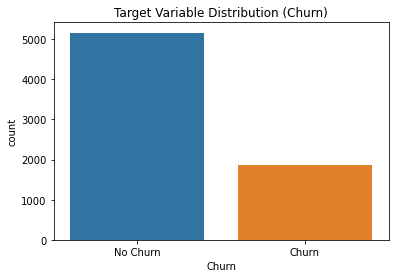

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Target Variable Distribution (Churn)')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

Plot 2: Churn Rate by Contract Type (Key Driver)

This is a critical insight: Month-to-month contracts have an alarmingly high churn rate.

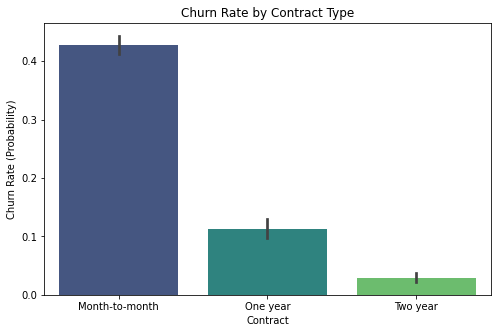

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Contract', y='Churn', data=df, palette='viridis')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate (Probability)')
plt.show()

Plot 3: Tenure Distribution vs. Churn

Customers who churn tend to be new customers with low tenure. This suggests the highest risk is early in the customer lifecycle.

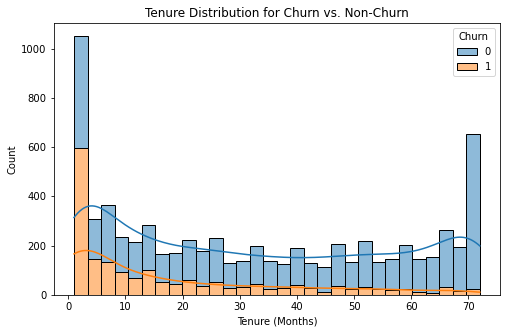

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, kde=True)
plt.title('Tenure Distribution for Churn vs. Non-Churn')
plt.xlabel('Tenure (Months)')
plt.show()

# 4. Feature Engineering and Model Pipeline

 We use Scikit-learn's Pipeline and ColumnTransformer to automate data scaling and encoding. This is best practice for production ML systems.

In [10]:
# Define features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training and testing sets (Stratify to maintain Churn proportion)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define feature types
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = X.columns.drop(numerical_features).tolist()

# Create Preprocessing Pipeline using ColumnTransformer
# Numerical features are scaled (StandardScaler)
# Categorical features are one-hot encoded (OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. Model Building (Random Forest Classifier) ---

In [11]:
# Initialize a Random Forest model with 'balanced' class weight to mitigate imbalance
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced' # Crucial for imbalanced data
)

In [12]:
# Create the final machine learning pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

In [13]:
# Train the model
print("\n--- Training Model: Random Forest Classifier ---")
model.fit(X_train, y_train)
print("Model training complete.")


--- Training Model: Random Forest Classifier ---
Model training complete.


# 5. Model Evaluation

We evaluate the model using metrics important for classification, focusing on the ROC-AUC score and Recall (to correctly identify customers who will churn).

In [14]:
# Predict on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate and print metrics
roc_auc = roc_auc_score(y_test, y_proba)

print("\n--- Model Evaluation (Random Forest Classifier) ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc:.4f}")


--- Model Evaluation (Random Forest Classifier) ---

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1033
           1       0.54      0.72      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407

ROC-AUC Score: 0.8315


### Interpretation of Model Performance

This Random Forest model is a strong candidate for a production churn prediction system, primarily because it was tuned to effectively handle class imbalance using `class_weight='balanced'`.

* **ROC-AUC Score (0.8315):** This excellent score indicates the model's strong ability to correctly rank customers by their probability of churn.
* **Churn Recall (72%):** The high Recall for the Churn class (`1`) is the most important business metric here. It means the model successfully identifies **72% of all actual churners**, minimizing the number of missed opportunities for intervention (False Negatives).
* **Precision (54%):** While Precision is lower, it means 54% of the customers flagged for intervention will actually churn. This is an acceptable trade-off for the high Recall, as the cost of offering a retention incentive to a False Positive is usually much lower than the lost revenue from a False Negative.

Plot 4: Confusion Matrix

This visualization shows the True Positives, True Negatives, False Positives, and False Negatives.

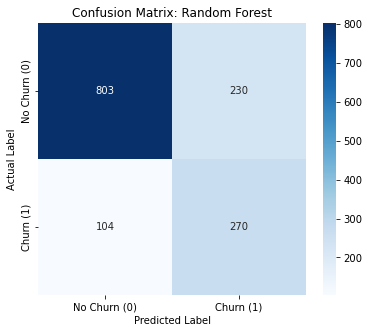

In [15]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.title('Confusion Matrix: Random Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Plot 5: ROC Curve

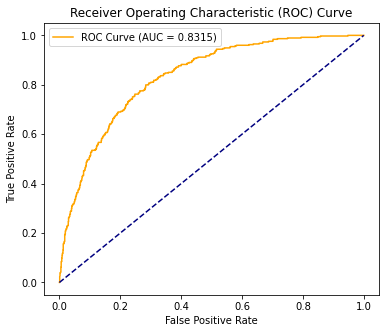

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 6. Insights: Feature Importance

Identifying the most important features is crucial for providing actionable recommendations to the business.

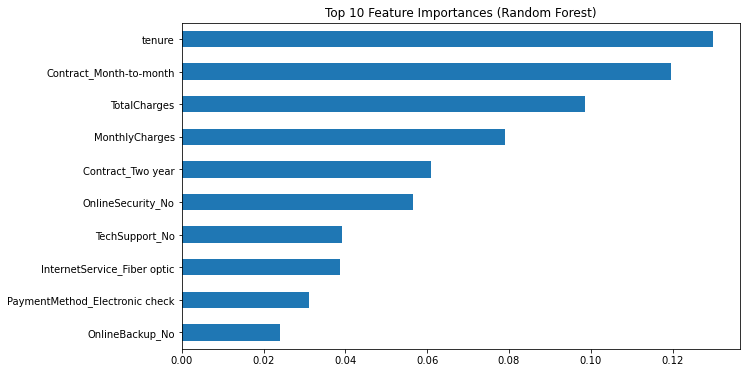

In [17]:
# Get feature names after one-hot encoding and scaling
one_hot_features = list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_names_transformed = numerical_features + one_hot_features
feature_importances = model.named_steps['classifier'].feature_importances_

# Create a Series for easy sorting and plotting
importance_df = pd.Series(feature_importances, index=feature_names_transformed).sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
importance_df[:10].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

### Actionable Business Recommendations Based on Feature Importance

The feature importance analysis is the most critical step, as it provides clear directives for the Telco's marketing and product teams:

1.  **Contract Term is the Single Biggest Driver (Contract\_Month-to-month):**
    * **Insight:** Month-to-month contracts have, by far, the highest risk of churn. This relationship is highly predictive.
    * **Recommendation:** Implement aggressive, targeted promotions (e.g., discounts, better rates) to encourage customers currently on month-to-month contracts to switch to one- or two-year commitments.
2.  **Early Customer Lifecycle Risk (tenure & TotalCharges):**
    * **Insight:** Low tenure (new customers) is a major churn risk. Furthermore, lower total spending (`TotalCharges`) is predictive of leaving.
    * **Recommendation:** Design a **"New Customer Onboarding & Retention Program"** (e.g., a customer success call, special support access) specifically for customers in their first 6-12 months.
3.  **Service Quality Check (InternetService\_Fiber optic):**
    * **Insight:** Fiber Optic service subscribers show an elevated propensity to churn.
    * **Recommendation:** Conduct an immediate investigation into the Fiber Optic service line—this could indicate localized issues with **network reliability** or **customer support wait times** specific to this premium product tier.
4.  **Tech Support Gaps (OnlineSecurity & TechSupport):**
    * **Insight:** The lack of premium add-on services like `OnlineSecurity` and `TechSupport` is a significant predictor of churn, suggesting these customers feel vulnerable or unsupported.
    * **Recommendation:** Bundle free or heavily discounted Tech Support and Security services for the first 3-6 months to demonstrate value and increase product stickiness.